## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Adagrad, Adadelta
from keras_tuner.tuners import RandomSearch

## Data Preprocessing

In [2]:
# Load the dataset
dataset = pd.read_csv("cardio_dataset.csv")
dataset.head()

,SEX,AGEIR,TC,HDL,SMOKE_,BPMED,DIAB_01,RISK
0,2,48,236,66,0,2,0,1.1
1,1,48,260,51,0,2,1,7.0
2,1,44,187,49,1,2,0,7.0
3,2,42,216,57,1,2,0,0.4
4,2,56,156,42,0,2,0,2.2


## Split Target and Features

In [3]:
data = dataset.iloc[:,0:7].values
target = dataset.iloc[:,7].values

## Scaling

In [4]:
target=np.reshape(target, (-1,1))

scaler_data = MinMaxScaler(feature_range=(0,1))
scaler_target = MinMaxScaler()

data_scaled=scaler_data.fit_transform(data)
target_scaled=scaler_target.fit_transform(target)

## Train Test Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_scaled, target_scaled,test_size=0.2)

## Neural Network Architecture

### Keras Tuner ( Hyper Parameter Optimization )

In [6]:
def build_model(parameters):
    
    model = Sequential()
    
    for i in range(parameters.Int("#layers ", 2,20)):      #number of layers gana num_layers kynne.
                                                          #2-20 athra random num ekak thorla denwa.10 unth loop eka 10 parak run wnw.
        
                                                          # palaweni iteration ekedi units wlt random value ekak denwa.
                                                          # min 32 and max 512 step eka 32i ethkt 32 , 64 wge 32n 32t random value ekak gnnwa
                                                          # parametr choice eke randomly relu sigmoid wge euwa gnnwa.
                                                          # i=0 welwata wenma ekk declare krnne palaweni layer eke input dim gana denna oni nisa.
        if(i==0):
            model.add(Dense(units=parameters.Int("#neuron layer " + str(i), min_value=32, max_value=515, step=32),
                            activation=parameters.Choice("activation function " + str(i), ["relu", "sigmoid", "tanh"]), input_dim=7))
            
            model.add(Dropout(parameters.Choice("drop probability ",([0.2, 0.3, 0.4, 0.5]))))    # drop out wltath random probability ekak denwa. 
            
        else:
            model.add(Dense(units=parameters.Int("#neuron layer " + str(i), min_value=32, max_value=512, step=32),
                           activation=parameters.Choice("activation function " + str(i), ["relu", "sigmoid", "tanh"])))
                      
            model.add(Dropout(parameters.Choice("drop probability ", ([0.2, 0.3, 0.4, 0.5]))))
                      
    model.add(Dense(1, activation="linear"))              # last layer liner , regression problem nisa.    
    
    # compile
    model.compile(optimizer=parameters.Choice("optimizer ", ["adam", "adadelta", "adagrad"]), 
                  loss=parameters.Choice("loss function", ["mse", "mae"]))   # random optimizer 3k denwa ekak gnna.
                    
    # model.compile(optimizer=Adam(parameters.Choice(learning_rate=[1e-2, 1e-3, 1e-4])), loss="mse")
    # model.compile(optimizer=AdaDelta(parameters.Choice(learning_rate=[1e-2, 1e-3, 1e-4])), loss="mse")
    # model.compile(optimizer=AdaGrade(parameters.Choice(learning_rate=[1e-2, 1e-3, 1e-4])), loss="mse")
                      
    return model      

In [7]:
tuner = RandomSearch(build_model, objective="val_loss", max_trials=5, executions_per_trial=3, directory="project", 
                     project_name="Heart-Risk")

# tuner means an object from tuner library
# build_model kiyanne model ek hdna function eka
# regression nisa val_loss e wtrk nwi mean squared error wge oni ekk use krnna puluwan
# max_trials means randomly neural netowrk kyk thornwda kyn eka. loku welawak yana nisa 5 damme 
# eka neural netowrk ek ki parak run krnwd kyn eka
# neural netork save wena thena folder name eka project
# project name eka define karanawa

Reloading Tuner from project\Heart-Risk\tuner0.json


[more info](https://keras-team.github.io/keras-tuner/)

## Get The Summary
#### Can get hypherparameter summary

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 36
#layers  (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
#neuron layer 0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 515, 'step': 32, 'sampling': 'linear'}
activation function 0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
drop probability  (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
#neuron layer 1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation function 1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
optimizer  (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adadelta', 'adagrad'], 'ordered': False}
loss function (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered':

## Search Best Parameters For The Model

In [9]:
tuner.search(x_train, y_train, epochs=200, validation_data=(x_test, y_test))

In [10]:
tuner.results_summary()                             # dropout probabilities and activation functions details can get here

Results summary
Results in project\Heart-Risk
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
#layers : 7
#neuron layer 0: 288
activation function 0: relu
drop probability : 0.4
#neuron layer 1: 192
activation function 1: sigmoid
optimizer : adam
loss function: mse
#neuron layer 2: 480
activation function 2: relu
#neuron layer 3: 352
activation function 3: relu
#neuron layer 4: 160
activation function 4: relu
#neuron layer 5: 64
activation function 5: relu
#neuron layer 6: 192
activation function 6: sigmoid
#neuron layer 7: 256
activation function 7: sigmoid
#neuron layer 8: 96
activation function 8: relu
#neuron layer 9: 352
activation function 9: tanh
#neuron layer 10: 192
activation function 10: tanh
Score: 0.00296808957743148

Trial 3 summary
Hyperparameters:
#layers : 9
#neuron layer 0: 64
activation function 0: tanh
drop probability : 0.5
#neuron layer 1: 256
activation function 1: relu
optimizer : adadelta
loss function: mse
#

In [11]:
best_model = tuner.get_best_models()
print(f"Best Model: {best_model[0].summary()} ")    # Layers details can get here

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 288)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 192)                 │          55,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 480)                 │          92,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 352)                 │         169,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 160)                 │          56,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 192)                 │          12,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399,201 (1.52 MB)

 Trainable params: 399,201 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

Best Model: None 


## Neuran Network Architechture

In [12]:
model = Sequential()

model.add(Dense(288, input_dim=7, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(192, activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(480, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(352, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(160, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(192, activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

# compile
model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 288)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 192)                 │          55,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 480)                 │          92,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 352)                 │         169,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 160)                 │          56,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 192)                 │          12,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399,201 (1.52 MB)

 Trainable params: 399,201 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

## Train The Model

In [13]:
model.fit(x_train, y_train, epochs=1000, validation_split=0.2)

Epoch 1/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0725 - mae: 0.1859 - mse: 0.0725 - val_loss: 0.0312 - val_mae: 0.1167 - val_mse: 0.0312
Epoch 2/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300 - mae: 0.1219 - mse: 0.0300 - val_loss: 0.0074 - val_mae: 0.0545 - val_mse: 0.0074
Epoch 3/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - mae: 0.0748 - mse: 0.0129 - val_loss: 0.0066 - val_mae: 0.0522 - val_mse: 0.0066
Epoch 4/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mae: 0.0690 - mse: 0.0108 - val_loss: 0.0055 - val_mae: 0.0485 - val_mse: 0.0055
Epoch 5/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - mae: 0.0659 - mse: 0.0097 - val_loss: 0.0051 - val_mae: 0.0491 - val_mse: 0.0051
Epoch 6/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - mae: 0.0641 - mse: 0.0087 - val_loss: 0.0054 - val_mae: 0.0467 - val_mse: 0.0054
Epoch 7/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - mae: 0.0618 - mse

## Model Evaluation

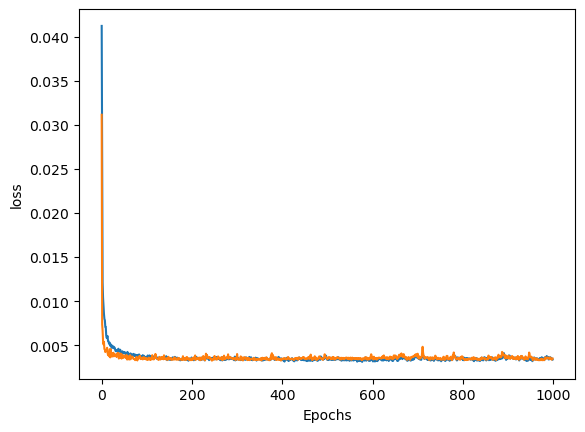

In [14]:
# Plot
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [15]:
# r2 score

y_pred = model.predict(x_test) 

r2 = r2_score(y_test, y_pred)
print("r2 score: ", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
r2 score:  0.8788827631390324


In [16]:
print("actual: ", y_test[:10])
print("predicted: ", y_pred[:10].T) 

actual:  [[0.01641266]
 [0.16060961]
 [0.        ]
 [0.00234467]
 [0.04220399]
 [0.58382181]
 [0.22391559]
 [0.00117233]
 [0.06682298]
 [0.1922626 ]]
predicted:  [[0.01383723 0.07130415 0.01159398 0.01159398 0.01159398 0.4645714
  0.4000977  0.01159398 0.07479145 0.32185715]]


In [17]:
# Print the results without scaling
print("actual inverse scaled: ", scaler_target.inverse_transform(y_test[:10].T))
print("predicted inverse scaled", scaler_target.inverse_transform(y_pred[:10].T))

actual inverse scaled:  [[ 1.5 13.8  0.1  0.3  3.7 49.9 19.2  0.2  5.8 16.5]]
predicted inverse scaled [[ 1.2803159  6.1822443  1.0889661  1.0889661  1.0889661 39.72794
  34.228333   1.0889661  6.4797106 27.554415 ]]
